In [1]:
import torch
import os
from dataset import CDEDataset
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available(): 
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device

device(type='cuda', index=0)

In [2]:
no_dilation_models = []
for i in range(10):
    no_dilation_models.append(torch.load(f"Models/dilationNone/conv_{i+1}_800.pt"))
    
dilation_2_models = []
for i in range(10):
    dilation_2_models.append(torch.load(f"Models/dilation2/dil2_{i+1}_800.pt"))
    
aspp_models = []
for i in range(10):
    aspp_models.append(torch.load(f"Models/aspp/aspp_{i+1}_800.pt"))

In [3]:
root_ims = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_A/test_data/images'
root_ann = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_A/test_data/density_gt'
im_list = os.listdir(root_ims)
test_SH_A = CDEDataset(im_list,root_ims,root_ann, transform  = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train =False)

root_ims = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_B/test_data/images'
root_ann = '../CDE_Data/ShanghaiTech/ShanghaiTech/part_B/test_data/density_gt'
im_list = os.listdir(root_ims)
test_SH_B = CDEDataset(im_list,root_ims,root_ann, transform  = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train =False)

root_ims = '../CDE_Data/UCF_CC_50/images'
root_ann = '../CDE_Data/UCF_CC_50/density_gt'
im_list = os.listdir(root_ims)
test_UCF = CDEDataset(im_list,root_ims,root_ann, transform  = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train =False)

In [4]:
test_SH_A_dataloader = DataLoader(test_SH_A, batch_size=1, shuffle=True)
test_SH_B_dataloader = DataLoader(test_SH_B, batch_size=1, shuffle=True)
test_UCF_dataloader = DataLoader(test_UCF, batch_size=1, shuffle=True)

test_dataloaders = [test_SH_A_dataloader, test_SH_B_dataloader, test_UCF_dataloader]

In [5]:
counts = []
for a in test_UCF:
    counts.append(a[2])
counts = np.array(counts)

In [6]:
counts.max()

4633

In [7]:
def evaluate(model,dataloaders):

    maes = []
    mses = []
    for loader in dataloaders:
        losses =[]

        model.eval()
        with torch.no_grad():    
            for i, data in enumerate(loader, 0):
                # evaluate the model on the test set
                inputs, labels, true_count = data


                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                pred_count = np.sum(outputs[0][0].cpu().detach().numpy())
                true_count = true_count.cpu().detach().numpy()

                losses.append(pred_count - true_count)

                #print(i, end = " ")
        mae = np.mean(np.abs(losses))
        mse = np.sqrt(np.mean(np.square(losses)))
        maes.append(mae)
        mses.append(mse)
        #print('.', end = " ")
    print('.', end = " ")
    return maes, mses
        

In [14]:

for model in dilation_2_models:
    print(model)
    

BaseNet(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

In [8]:
no_dil_maes = []
no_dil_mses = []

for model in no_dilation_models:
    maes, mses = evaluate(model, test_dataloaders)
    no_dil_maes.append(maes)
    no_dil_mses.append(mses)
    
no_dil_maes = np.array(no_dil_maes)
no_dil_mses = np.array(no_dil_maes)
    
dil_2_maes = []
dil_2_mses = []

for model in dilation_2_models:
    maes, mses = evaluate(model, test_dataloaders)
    dil_2_maes.append(maes)
    dil_2_mses.append(mses)

dil_2_maes = np.array(dil_2_maes)
dil_2_mses = np.array(dil_2_mses)
    
aspp_maes = []
aspp_mses = []

for model in aspp_models:
    maes, mses = evaluate(model, test_dataloaders)
    aspp_maes.append(maes)
    aspp_mses.append(mses)
    
aspp_maes = np.array(aspp_maes)
aspp_mses = np.array(aspp_mses)   

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Thishen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-0f85525539ce>", line 5, in <module>
    maes, mses = evaluate(model, test_dataloaders)
  File "<ipython-input-7-fa84c9e69d92>", line 19, in evaluate
    pred_count = np.sum(outputs[0][0].cpu().detach().numpy())
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Thishen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Thishen\anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_recor

TypeError: object of type 'NoneType' has no len()

In [ ]:
import csv

# open the file in the write mode
with open('path/to/csv_file', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(row)

In [13]:
np.mean(no_dil_maes, axis = 0)

array([106.67824095,  45.29564267, 508.52970059])

In [19]:
np.mean(dil_2_maes[:9], axis = 0)

array([ 89.52933715,  35.77369534, 418.04720121])

In [15]:
np.mean(aspp_maes, axis = 0)

array([ 81.86495679,  25.40276446, 426.47964265])

In [16]:
np.min(no_dil_maes, axis = 0)

array([ 89.39784958,  20.39981904, 426.25853104])

In [4]:
dil_A = dil[:,0]
asp_A = asp[:,0]
con_A = con[:,0]

data = [con[:,0], dil[:,0], asp[:,0]]
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)


ax.set_xticklabels(['Baseline Approach', 'Dilated Convolution Approach',
                    'ASPP Approach'])
#ax.set_xticks(['no dilation model', 'dilation rate = 2', 'ASPP model'])
# show plot
plt.show()

NameError: name 'dil' is not defined

In [53]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dil_A, asp_A)
print(p)

0.0011011099712485391


inference time: 0.003994941711425781
actual:  289
predicted:  252.84067


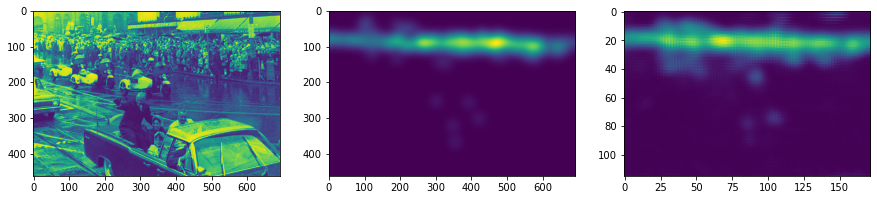

In [9]:
ex = test_SH_A[9]
im = ex[0].unsqueeze(0).to(device)
im.shape

start = time.time()
a = aspp_models[0](im)

print("inference time:", time.time() - start)
print("actual: ",ex[2])
print("predicted: ",np.sum(a[0][0].cpu().detach().numpy()))

fig, axs = plt.subplots(1, 3, figsize=(15,20))
axs[0].imshow(ex[0][0].detach().numpy())
axs[1].imshow(ex[1][0].detach().numpy())
axs[2].imshow(a[0][0].cpu().detach().numpy())
plt.show()

In [8]:
aspp_models[0]

ASPPNet(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
  (aspp1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1